# Kaggle Bike Sharing Demand(レンタサイクルの需要予測)

## データの読み込み

In [329]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # グラフ描画用
import seaborn as sns; sns.set() # グラフ描画用
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # モデル評価用(平均二乗誤差)
from sklearn.metrics import r2_score # モデル評価用(決定係数)

In [330]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
df = pd.read_csv('output/df_prepro_one-hot-encoding.csv')
submission = pd.read_csv('input/sampleSubmission.csv')
display(df.head())
# display(df.info())

,datetime,temp,humidity,windspeed,casual,registered,hour,casual_mov_ave,registered_mov_ave,weather_1,...,weekday_Thu,weekday_Tue,weekday_Wed,season_rev_1,season_rev_2,season_rev_3,season_rev_4,day_type_holiday,day_type_weekend,day_type_workingday
0,2011-01-01 00:00:00,9.84,81,0.0,3.0,13.0,0,NaN,NaN,1,...,0,0,0,0,0,0,1,0,1,0
1,2011-01-01 01:00:00,9.02,80,0.0,8.0,32.0,1,NaN,NaN,1,...,0,0,0,0,0,0,1,0,1,0
2,2011-01-01 02:00:00,9.02,80,0.0,5.0,27.0,2,NaN,NaN,1,...,0,0,0,0,0,0,1,0,1,0
3,2011-01-01 03:00:00,9.84,75,0.0,3.0,10.0,3,NaN,NaN,1,...,0,0,0,0,0,0,1,0,1,0
4,2011-01-01 04:00:00,9.84,75,0.0,0.0,1.0,4,NaN,NaN,1,...,0,0,0,0,0,0,1,0,1,0


In [331]:
df.drop([
    'datetime'
#             'year', 
#              'month', 
#              'weekday', 
#              # 'hour', 
#              'day_type', 
#              'weather', 
#              # 'temp',
#              # 'humidity', 
#              # 'windspeed', 
#              # 'casual', 
#              # 'registered', 
#              # 'casual_mov_ave',
#              # 'registered_mov_ave',
            ],axis=1,
             inplace=True)

In [332]:
df.columns

Index(['temp', 'humidity', 'windspeed', 'casual', 'registered', 'hour',
       'casual_mov_ave', 'registered_mov_ave', 'weather_1', 'weather_2',
       'weather_3', 'weather_4', 'weekday_Fri', 'weekday_Mon', 'weekday_Sat',
       'weekday_Sun', 'weekday_Thu', 'weekday_Tue', 'weekday_Wed',
       'season_rev_1', 'season_rev_2', 'season_rev_3', 'season_rev_4',
       'day_type_holiday', 'day_type_weekend', 'day_type_workingday'],
      dtype='object')

## 対数変換

In [333]:
def y_transform(df, col):
    # df[col] = np.sqrt(df[col])
    count_min  = df.loc[df[col].values > 0, col].min() #0を除いた最小値
    df[col] = train[col] + count_min
    df[col] = np.log(df[col])
    
# log_transform('temp')
# log_transform('humidity')
# log_transform('windspeed')
# y_transform(df, 'casual_mov_ave')
# y_transform(df, 'registered_mov_ave')
# y_transform(df, 'casual')

# count_min = df.loc[df['casual'].values > 0, 'casual'].min() #0を除いた最小値
# df['casual'] = df['casual'] + count_min
# df['casual'] = np.log(df['casual'])


# df['casual'].describe()

## 機械学習
trainデータを分割してcasualとregisteredを目的変数に設定

In [334]:
df.drop(['registered_mov_ave'], axis=1, inplace=True)
train = df.iloc[:len(train),:].copy()
test  = df.iloc[len(train):,:].copy()
test.drop(['casual','registered'], axis=1, inplace=True)

### casualを学習

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 46.8449
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 43.52
[3]	valid_0's rmse: 40.5627
[4]	valid_0's rmse: 37.8573
[5]	valid_0's rmse: 35.4927
[6]	valid_0's rmse: 33.4262
[7]	valid_0's rmse: 31.6454
[8]	valid_0's rmse: 29.9999
[9]	valid_0's rmse: 28.6512
[10]	valid_0's rmse: 27.4213
[11]	valid_0's rmse: 26.3327
[12]	valid_0's rmse: 25.426
[13]	valid_0's rmse: 24.6039
[14]	valid_0's rmse: 23.9437
[15]	valid_0's rmse: 23.2921
[16]	valid_0's rmse: 22.8026
[17]	valid_0's rmse: 22.2976
[18]	valid_0's rmse: 21.8713
[19]	valid_0's rmse: 21.4957
[20]	valid_0's rmse: 21.1812
[21]	valid_0's rmse: 20.872
[22]	valid_0's rmse: 20.6441
[23]	valid_0's rmse: 20.3999
[24]	valid_0's rmse: 20.2039
[25]	valid_0's rmse: 20.02

/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


,train,train_pred
6638,44.0,31.491611
7975,30.0,26.399504
5915,18.0,19.542986
8050,98.0,93.559167
5894,20.0,28.781304
...,...,...
1277,4.0,6.411851
2587,83.0,77.784913
7950,72.0,64.171346
9878,9.0,12.808015


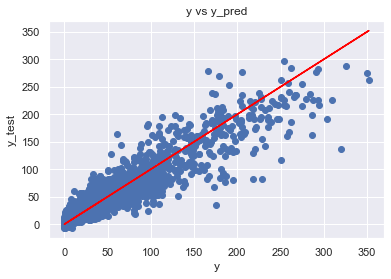

RMSE : 18.054358067226264
R2 : 0.872551476440748


In [335]:
X = train.drop(['casual','registered'], axis=1)
y = train['casual']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=0)

# ---------- 

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train) 

# LightGBM parameters
params = {
        'task': 'predict',
        'boosting_type': 'gbdt',
        'objective': 'regression', # 目的 : 回帰  
        'metric': {'rmse'}, # 評価指標 : rsme(平均二乗誤差の平方根) 
        'learning_rate': 0.1,
        'num_leaves': 23,
        'min_data_in_leaf': 1,
        'num_trees': 100, #1000回学習
        'verbose': 0
}

# モデルの学習
model = lgb.train(params, # パラメータ
            # categorical_feature=[
                # 'year',
                # 'month',
                # 'weekday',
                # 'hour',
                # 'day_type',
                # 'weather',
                # '',
                # '',
                # '',
            # ],
            train_set=lgb_train, # トレーニングデータの指定
            valid_sets=lgb_eval, # 検証データの指定
            early_stopping_rounds=100 # 100回ごとに検証精度の改善を検討　→ 精度が改善しないなら学習を終了(過学習に陥るのを防ぐ)
               )

# テストデータの予測
y_pred = model.predict(X_test)
# y_pred = np.log((np.exp(y_pred) - count_min).astype('int'))

# 真値と予測値の表示
df_pred = pd.DataFrame({'train':y_test,'train_pred':y_pred})
display(df_pred)

# 散布図を描画(真値 vs 予測値)
plt.plot(y_test, y_test, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
plt.scatter(y_test, y_pred) # 散布図のプロット
plt.xlabel('y') # x軸ラベル
plt.ylabel('y_test') # y軸ラベル
plt.title('y vs y_pred') # グラフタイトル
plt.show()

# ---------- 

# モデル評価
# rmse : 平均二乗誤差の平方根
mse = mean_squared_error(y_test, y_pred) # MSE(平均二乗誤差)の算出
rmse = np.sqrt(mse) # RSME = √MSEの算出
print('RMSE :',rmse)

# r2 : 決定係数
r2 = r2_score(y_test,y_pred)
print('R2 :',r2)

test_pred = model.predict(test)
test_pred = pd.DataFrame(test_pred,  columns=['casual'])
# return test_pred

In [336]:
test_pred['casual'].min()
# test_pred['casual'] = test_pred['casual']*count_max
# test_pred['casual'] = test_pred['casual']

# count_min = df.loc[df['casual'].values > 0, 'casual'].min() #0を除いた最小値(=1)
# count_max = df['casual'].max()
# df['casual'] = df['casual'] + count_min
# df['casual'] = df['casual']/count_max #0~1になる

-9.98483165182296

In [337]:
# def inv_transform(trg, count_min):
#     count = machine_learning(trg)[trg]
#     count = np.exp(count) - count_min
#     return count

In [338]:
# submission['count'] = inv_transform('casual', count_min) + inv_transform('registered', count_min)
# submission['count'] = round(submission['count'],0).astype('int')

In [339]:
# submission.describe()

In [340]:
# submission.to_csv('output/submission.csv',index=False)

In [341]:
# df.to_csv('output/df_prepro.csv',index=False)